In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta


In [15]:
# Download historical stock data for 'GBTC' from Yahoo Finance
# Start date: March 11, 2014
# End date: July 10, 2023
data = yf.download(tickers='GBTC', start='2014-03-11', end='2023-07-10')

# Display the first 10 rows of the downloaded data
data.head(10)


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-11,0.636813,0.636813,0.549451,0.549451,0.549451,245700
2015-05-12,0.549560,0.549560,0.538462,0.548901,0.548901,200200
2015-05-13,0.538462,0.538462,0.538462,0.538462,0.538462,27300
2015-05-14,0.538462,0.538462,0.483516,0.494505,0.494505,1810900
2015-05-15,0.494505,0.494505,0.417582,0.417582,0.417582,209300
2015-05-18,0.417582,0.417582,0.298352,0.298352,0.298352,455000
2015-05-19,0.307692,0.324176,0.306593,0.318681,0.318681,391300
2015-05-20,0.324176,0.354396,0.321429,0.346154,0.346154,445900
2015-05-21,0.340659,0.351648,0.335165,0.351648,0.351648,263900


In [16]:
from sklearn.preprocessing import MinMaxScaler  # Import the MinMaxScaler from scikit-learn

def data_set_scaled(data):
    """Scales the data to a range of 0 to 1.

    Args:
        data: A Pandas DataFrame containing the data to be scaled.

    Returns:
        A Pandas DataFrame containing the scaled data.
    """
    # Create a MinMaxScaler object that scales data to a range of 0 to 1
    sc = MinMaxScaler(feature_range=(0, 1))

    # Scale the data using the scaler
    data_scaled = sc.fit_transform(np.copy(data))

    # Return the scaled data as a Pandas DataFrame
    return data_scaled

def create_X_and_y_arrays(data_scaled, backcandles):
    """Creates the X and y arrays for the LSTM model.

    Args:
        data_scaled: A Pandas DataFrame containing the scaled data.
        backcandles: The number of backcandles to use as input to the LSTM model.

    Returns:
        A tuple containing the X and y arrays.
    """

    X = []
    for i in range(backcandles, data_scaled.shape[0]):
        # Create input sequences (X) with a sliding window of 'backcandles' length
        X.append(data_scaled[i - backcandles : i, :])

    # Create target values (y) based on the next data point after the input sequence
    y = data_scaled[backcandles:, -1]

    # Reshape X and y arrays for compatibility with LSTM input
    X = np.reshape(X, (len(X), backcandles, 8))
    y = np.reshape(y, (len(y), 1))

    # Return a tuple containing the input and output arrays (X, y)
    return X, y



In [17]:
# Adding technical indicators to the 'data' DataFrame
data['RSI'] = ta.rsi(data.Close, length=15)  # Relative Strength Index (RSI) with a 15-day period
data['EMAF'] = ta.ema(data.Close, length=20)  # Exponential Moving Average (EMA) with a 20-day period
data['EMAM'] = ta.ema(data.Close, length=100)  # EMA with a 100-day period
data['EMAS'] = ta.ema(data.Close, length=150)  # EMA with a 150-day period

# Calculate the 'Target' variable as the difference between 'Adj Close' and 'Open' prices
data['Target'] = data['Adj Close'] - data.Open

# Shift the 'Target' variable by one time step to represent the next day's change
data['Target'] = data['Target'].shift(-1)

# Create a binary 'TargetClass' variable: 1 if 'Target' is positive, 0 otherwise
data['Target Class'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]

# Create a 'TargetNextClose' variable as the 'Adj Close' shifted by one time step
data['Target Next Close'] = data['Adj Close'].shift(-1)

# Remove rows with missing values (NaN) from the DataFrame
data.dropna(inplace=True)

# Reset the DataFrame index
data.reset_index(inplace=True)

# Remove the 'Volume', 'Close', and 'Date' columns from the DataFrame
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)


In [18]:
# Select a subset of columns from the 'data' DataFrame
data_set = data.iloc[:, 0:11]


# Set an option to display all columns when printing the DataFrame
pd.set_option('display.max_columns', None)

# Display the first 20 rows of the 'data_set' DataFrame
data_set.head(20)


,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,Target Class,Target Next Close
0,0.708791,0.708791,0.596154,0.637363,70.174400,0.518566,0.403176,0.360513,-0.010989,0,0.692308
1,0.703297,0.736264,0.660989,0.692308,74.122990,0.535112,0.408902,0.364908,-0.016484,0,0.675824
2,0.692308,0.703297,0.615385,0.675824,71.097435,0.548514,0.414187,0.369026,0.000000,0,0.714286
3,0.714286,0.714286,0.692418,0.714286,73.773657,0.564301,0.420130,0.373599,-0.047692,0,0.694066
4,0.741758,0.758242,0.692308,0.694066,70.116697,0.576660,0.425554,0.377844,-0.020879,0,0.681319
5,0.702198,0.702198,0.675824,0.681319,67.845126,0.586627,0.430619,0.381863,-0.005494,0,0.681319
6,0.686813,0.691209,0.670879,0.681319,67.845126,0.595646,0.435583,0.385830,-0.011429,0,0.658791
7,0.670220,0.675824,0.648352,0.658791,63.660865,0.601660,0.440003,0.389445,-0.006594,0,0.652747
8,0.659341,0.659341,0.648352,0.652747,62.551925,0.606525,0.444216,0.392932,-0.010989,0,0.659341
9,0.670330,0.689560,0.649560,0.659341,63.299228,0.611555,0.448476,0.396461,-0.000220,0,0.690989


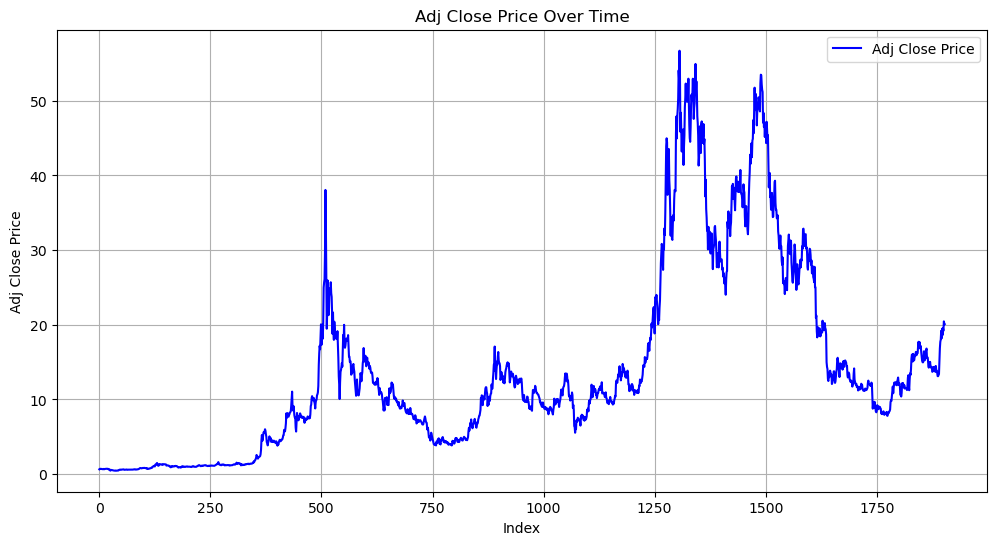

In [19]:
import matplotlib.pyplot as plt  # Import the matplotlib library

# Create a figure with a specified size (12 units wide and 6 units tall)
plt.figure(figsize=(12, 6))

# Plot the 'Adj Close' price over time using the DataFrame's index as the x-axis
plt.plot(data.index, data['Adj Close'], label='Adj Close Price', color='blue')

# Set the title of the plot
plt.title('Adj Close Price Over Time')

# Label the x-axis
plt.xlabel('Index')

# Label the y-axis
plt.ylabel('Adj Close Price')

# Display a grid in the plot
plt.grid(True)

# Display a legend with the label 'Adj Close Price'
plt.legend()

# Show the plot
plt.show()



In [20]:
from sklearn.preprocessing import MinMaxScaler  # Import the MinMaxScaler from scikit-learn

# Create a MinMaxScaler object with a specified feature range of 0 to 1
sc = MinMaxScaler(feature_range=(0, 1))

# Use the scaler to transform (scale) the data in 'data_set' and store the scaled data in 'data_set_scaled'
data_set_scaled = sc.fit_transform(data_set)

# Print the scaled data to the console
print(data_set_scaled)


[[0.00467178 0.00429974 0.00311802 ... 0.42882569 0.         0.00429798]
 [0.00457192 0.00477538 0.00432355 ... 0.4283808  0.         0.00400493]
 [0.00437219 0.00420462 0.0034756  ... 0.42971537 0.         0.0046887 ]
 ...
 [0.34258166 0.35300754 0.34959093 ... 0.4248576  0.         0.35003809]
 [0.3589399  0.34642852 0.36204874 ... 0.41595201 0.         0.34897142]
 [0.35984868 0.34400469 0.35014875 ... 0.42080962 0.         0.34417136]]


In [21]:
X = []  # Create an empty list to store the input features

# Set the number of backcandles, which is 30
backcandles = 30

# Iterate over features (j) in the data_set_scaled
for j in range(8):
    X.append([])  # Create a nested list for each feature

    # Iterate over the data, creating sequences of backcandles length for each feature
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i - backcandles:i, j])

# Move the axis from 0 to position 2 to format the data for model training
X = np.moveaxis(X, [0], [2])

# Extract the target variable (usually represented as 'y')
yi = data_set_scaled[backcandles:, -1]

# Reshape the target variable to match the input features
y = np.reshape(yi, (len(yi), 1))

# Print the shapes of X and y for inspection
print(X)
print(X.shape)
print(y)
print(y.shape)


[[[4.67177804e-03 4.29973848e-03 3.11802126e-03 ... 3.10386448e-04
   0.00000000e+00 0.00000000e+00]
  [4.57192028e-03 4.77538220e-03 4.32354671e-03 ... 6.42218159e-04
   1.36205946e-04 1.09752396e-04]
  [4.37218634e-03 4.20462005e-03 3.47559790e-03 ... 9.10963919e-04
   2.61949346e-04 2.12598463e-04]
  ...
  [2.27497296e-03 2.25450142e-03 2.45599195e-03 ... 2.22462080e-03
   2.44919418e-03 2.20155148e-03]
  [2.02531014e-03 1.77887420e-03 1.43233194e-03 ... 2.06981810e-03
   2.46183784e-03 2.22943675e-03]
  [1.47603721e-03 1.25567023e-03 1.94313845e-03 ... 1.92975851e-03
   2.47423114e-03 2.25695269e-03]]

 [[4.57192028e-03 4.77538220e-03 4.32354671e-03 ... 6.42218159e-04
   1.36205946e-04 1.09752396e-04]
  [4.37218634e-03 4.20462005e-03 3.47559790e-03 ... 9.10963919e-04
   2.61949346e-04 2.12598463e-04]
  [4.77165421e-03 4.39487444e-03 4.90792928e-03 ... 1.22757373e-03
   4.03321721e-04 3.26804967e-04]
  ...
  [2.02531014e-03 1.77887420e-03 1.43233194e-03 ... 2.06981810e-03
   2.46183

In [22]:
splitlimit = int(len(X) * 0.8)  # Calculate the index where the data will be split (80% for training)

# Print the split limit for reference
print(splitlimit)

# Split the input features (X) and target variable (y) into training and testing sets
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

# Print the shapes of the training and testing sets for both X and y
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Print the training data (y_train) for inspection
print(y_train)


1499
(1499, 30, 8)
(375, 30, 8)
(1499, 1)
(375, 1)
[[8.30301324e-04]
 [5.66565420e-04]
 [3.90723646e-04]
 ...
 [6.08173943e-01]
 [5.69595821e-01]
 [5.59817928e-01]]


In [23]:
# Import necessary libraries from Keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History
import numpy as np

# Seed for random number generation (to ensure reproducibility)
np.random.seed(10)

# Define the input shape for the LSTM layer
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')

# Create an LSTM layer with 150 units
inputs = LSTM(150, name='first_layer')(lstm_input)

# Add a Dense layer with 1 unit
inputs = Dense(1, name='dense_layer')(inputs)

# Apply the 'linear' activation function to the output
output = Activation('linear', name='output')(inputs)

# Create a Keras Model specifying inputs and outputs
model = Model(inputs=lstm_input, outputs=output)

# Define the Adam optimizer for training
adam = optimizers.Adam()

# Compile the model with mean squared error (MSE) as the loss function
model.compile(optimizer=adam, loss='mse')

# Train the model with training data (X_train, y_train)
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)


Epoch 1/30


2024-03-03 11:05:52.662620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-03 11:05:52.665091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-03 11:05:52.667562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

88/90 [============================>.] - ETA: 0s - loss: 0.0029

2024-03-03 11:05:56.556215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-03 11:05:56.559281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-03 11:05:56.561793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

90/90 [==============================] - 4s 24ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 2/30
90/90 [==============================] - 2s 17ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 3/30
90/90 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 4/30
90/90 [==============================] - 2s 17ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 5/30
90/90 [==============================] - 1s 16ms/step - loss: 9.5766e-04 - val_loss: 0.0033
Epoch 6/30
90/90 [==============================] - 1s 16ms/step - loss: 9.3039e-04 - val_loss: 0.0041
Epoch 7/30
90/90 [==============================] - 2s 20ms/step - loss: 9.1446e-04 - val_loss: 0.0020
Epoch 8/30
90/90 [==============================] - 2s 20ms/step - loss: 8.3453e-04 - val_loss: 0.0019
Epoch 9/30
90/90 [==============================] - 2s 18ms/step - loss: 8.3787e-04 - val_loss: 0.0025
Epoch 10/30
90/90 [==============================] - 2s 18ms/step - loss: 7.9596e-04 - val_loss: 0.0

In [24]:
# Evaluation Metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate the RMSE
rmse = np.sqrt(mse)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate the R2
r2 = r2_score(y_test, y_pred)

# Print the metrics
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)


MSE: 0.0006920025826666794
RMSE: 0.0263059419650139
MAE: 0.01996953166997406
R2: 0.9540370695013728


In [25]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)


# Loop through the first 10 predictions and actual test values for comparison
for i in range(10):
    print(y_pred[i], y_test[i])


 1/12 [=>............................] - ETA: 4s

2024-03-03 11:07:31.156118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-03 11:07:31.159467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-03 11:07:31.161961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 9ms/step
[0.6064564] [0.5383955]
[0.5888324] [0.52835095]
[0.5660249] [0.54577333]
[0.5497973] [0.55999571]
[0.5662338] [0.53421767]
[0.585632] [0.53475102]
[0.5647732] [0.49990622]
[0.5599314] [0.49012836]
[0.5274682] [0.50790631]
[0.51763064] [0.44692793]


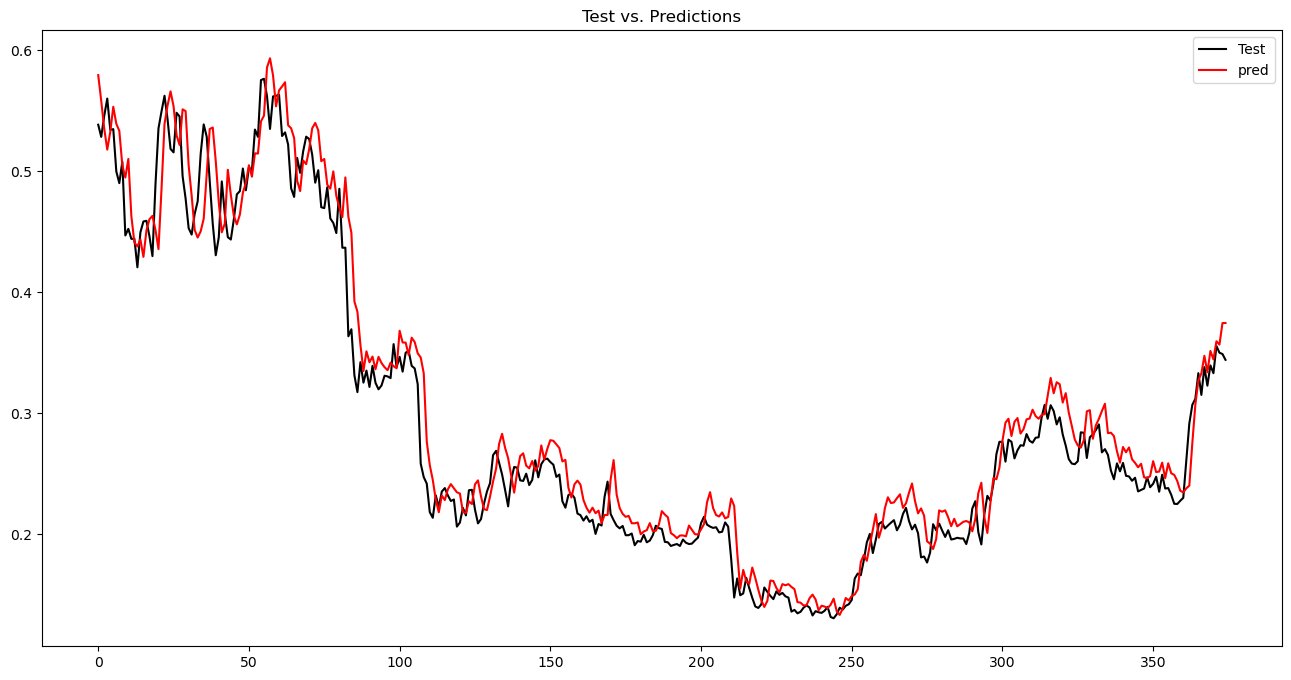

In [13]:
import matplotlib.pyplot as plt

# Create a figure for the plot with a specified size
plt.figure(figsize=(16, 8))

# Set the title of the plot
plt.title('Test vs. Predictions')

# Plot the actual test values (y_test) in black
plt.plot(y_test, color='black', label='Test')

# Plot the predicted values (y_pred) in red
plt.plot(y_pred, color='red', label='pred')

# Add a legend to the plot to distinguish between 'Test' and 'pred'
plt.legend()

# Display the plot
plt.show()
